In [7]:
%matplotlib inline
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
train = np.loadtxt('data/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('data/test.csv', delimiter=',', skiprows=1)

In [10]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

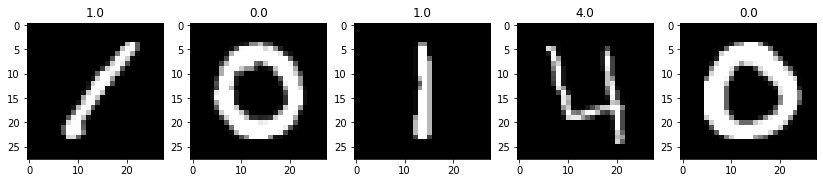

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [12]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [13]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

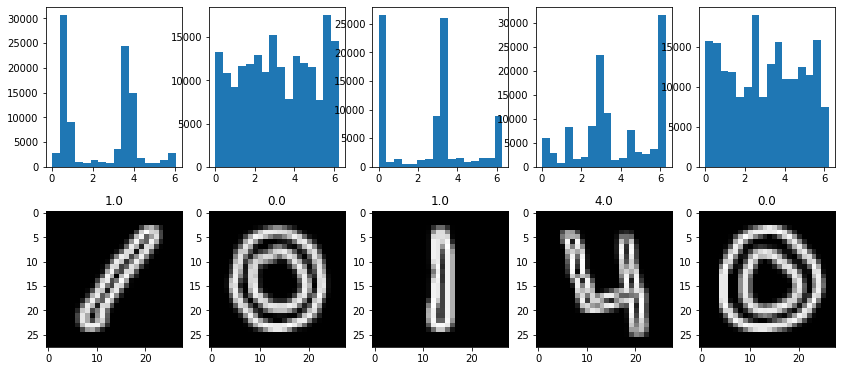

In [14]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [15]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [16]:
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [17]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Собираем полносвязную сеть для обучения

In [37]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(32,
                             input_dim=x_train.shape[1],
                             activation='relu'))
model.add(keras.layers.Dense(64,
                             input_dim=32,
                             activation='sigmoid'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Выводим информацию о модели

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 3,306
Trainable params: 3,306
Non-trainable params: 0
_________________________________________________________________


In [20]:
16*32+32

544

## One hot encoding разметки

In [21]:
y_train.shape

(33600,)

In [22]:
y_train[:10]

array([6., 5., 3., 4., 7., 8., 6., 7., 0., 9.])

In [23]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

In [24]:
y_train_labels[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

## Запускаем обучение

In [39]:
model.fit(x_train, y_train_labels, 
          batch_size=128, validation_split=0.2,
          epochs=10)

Epoch 1/10
210/210 [==============================] - 1s 2ms/step - loss: 2.2448 - accuracy: 0.1660 - val_loss: 1.8318 - val_accuracy: 0.3091
Epoch 2/10
210/210 [==============================] - 0s 1ms/step - loss: 1.7506 - accuracy: 0.3455 - val_loss: 1.5956 - val_accuracy: 0.4333
Epoch 3/10
210/210 [==============================] - 0s 1ms/step - loss: 1.5534 - accuracy: 0.4302 - val_loss: 1.4564 - val_accuracy: 0.4629
Epoch 4/10
210/210 [==============================] - 0s 1ms/step - loss: 1.4328 - accuracy: 0.4722 - val_loss: 1.3923 - val_accuracy: 0.4790
Epoch 5/10
210/210 [==============================] - 0s 1ms/step - loss: 1.3800 - accuracy: 0.4927 - val_loss: 1.3485 - val_accuracy: 0.4979
Epoch 6/10
210/210 [==============================] - 0s 1ms/step - loss: 1.3252 - accuracy: 0.5150 - val_loss: 1.3023 - val_accuracy: 0.5247
Epoch 7/10
210/210 [==============================] - 0s 1ms/step - loss: 1.2829 - accuracy: 0.5322 - val_loss: 1.2586 - val_accuracy: 0.5429
Epoch 

## Предсказываем класс объекта

In [40]:
pred_val = model.predict_classes(x_val)

In [41]:
pred_val[:5]

array([0, 1, 4, 7, 8], dtype=int64)

In [42]:
pred_proba = model.predict_proba(x_val)

In [43]:
pred_proba[:5]

array([[3.00724030e-01, 2.35990435e-03, 1.57337319e-02, 6.14316808e-03,
        4.34967875e-02, 1.45247101e-03, 1.93835631e-01, 7.73470057e-03,
        2.54991740e-01, 1.73527882e-01],
       [6.38326164e-05, 9.92350638e-01, 4.80507924e-06, 3.44911513e-07,
        4.94213309e-03, 3.05659484e-07, 7.53237473e-05, 2.09824624e-03,
        5.45011517e-06, 4.58766328e-04],
       [1.75247528e-02, 1.18798362e-02, 1.09652262e-02, 8.80813168e-04,
        5.47940969e-01, 3.71762144e-04, 8.15011337e-02, 1.15742624e-01,
        1.56510540e-03, 2.11627796e-01],
       [5.68575109e-04, 7.70190149e-04, 3.58875701e-03, 3.93783761e-04,
        3.70158553e-02, 1.14746776e-03, 4.64455551e-03, 8.99307787e-01,
        9.16462668e-05, 5.24714030e-02],
       [2.44443342e-01, 9.25985107e-04, 2.53218599e-02, 9.34038218e-03,
        1.74071398e-02, 3.12876375e-03, 2.16891438e-01, 1.79713815e-02,
        2.60835022e-01, 2.03734636e-01]], dtype=float32)

In [44]:
pred_proba[:5].argmax(axis=1)

array([0, 1, 4, 7, 8], dtype=int64)

## Оцениваем качество решение на валидационной выборке

In [45]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.575


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.33      0.17      0.23       816
         1.0       0.95      0.95      0.95       909
         2.0       0.42      0.26      0.32       846
         3.0       0.58      0.69      0.63       937
         4.0       0.67      0.60      0.63       839
         5.0       0.53      0.62      0.57       702
         6.0       0.38      0.40      0.39       785
         7.0       0.80      0.75      0.77       893
         8.0       0.44      0.58      0.50       835
         9.0       0.51      0.66      0.58       838

    accuracy                           0.57      8400
   macro avg       0.56      0.57      0.56      8400
weighted avg       0.57      0.57      0.56      8400



In [33]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[132  10  74  30  52  20 223   7 216  52]
 [  2 861   2   0  23   0   9   4   2   6]
 [ 29   0 237 208   6 147  52  40 104  23]
 [ 17   0  49 645   1 105   5   4  92  19]
 [ 15  34   4   1 517   0 100  56  16  96]
 [  0   0  66 142   0 421  11  13  45   4]
 [ 71   4  58  13  90   8 352  16  96  77]
 [  5   7  27  11  37  11  46 685   6  58]
 [ 83   0  28  61  20  43  64   6 475  55]
 [ 25   5  20  29  97   7  65  66  30 494]]


## Предсказания на тестовыйх данных

In [34]:
pred_test = model.predict_classes(test_hist)

## Визуализируем предсказания

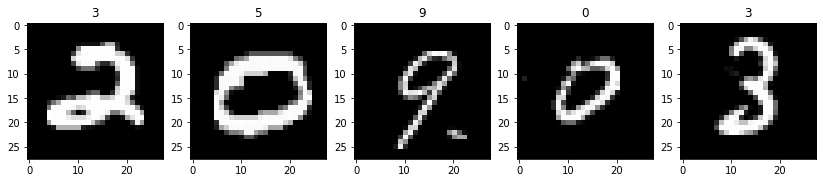

In [35]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);